# Reproduce ABC Analyses

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import itertools

### Stats
from scipy.stats import linregress, entropy
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine

### Custom functions
import cs as cs

### Plotting
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('MATPLOTLIBRC')
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import seaborn as sns

In [2]:
# constants for plotting
golden_ratio = 1.618
one_col_width = 3.405 # inches
two_col_width = 6.997 # inches
col_width = 5.2 # inches
max_width = 7.5 # inches

dpi=300

# number of bootstrap samples
N_B = 100_000

## Read data

In [3]:
url = 'https://raw.githubusercontent.com/DCMLab/ABC/master/data/all_annotations.tsv'

data = pd.read_csv(
    url, 
    sep='\t', 
    dtype={'figbass': str, 'changes':str}
)

## Preprocessing

There is a typo in the dataset. It contains a local modulation to `Ab` in a c-minor movement. It should be `VI` instead.

In [4]:
data[data.local_key=='Ab'][['chord', 'global_key', 'local_key']]

chord global_key local_key
16592  .Ab.I          c        Ab
16593    I64          c        Ab
16594      I          c        Ab
16595    V65          c        Ab
16596     V7          c        Ab
16597   viio          c        Ab
16598      I          c        Ab

In [5]:
data['local_key'].replace('Ab', 'VI', inplace=True)

Add mode columns

In [6]:
data['global_mode'] = np.where(data.global_key.str.istitle(), 'major', 'minor')
data['local_mode'] = np.where(data.local_key.str.istitle(), 'major', 'minor')

Transform `figbass` and `changes` column to `str`.

In [7]:
data['figbass'] = data['figbass'].str.replace('.0', '')
data['changes'] = data['changes'].str.replace('.0', '')

We create a new column that contains the tokens that will be the basis for the analysis. A token consists of a combination of parts of the chord symbol. The tokens for our analysis contain the following features:

In [8]:
token_parts = [
    'numeral',
    'form',
    'figbass',
    'changes',
    'relativeroot'
]

# initialize column, leave `@none` invariant
data['token'] = np.where( data['chord'] == '@none', '@none', '' )

# concatenate token parts to token
for token in token_parts:
    if data[token] is not None:
        s = data[token].fillna('')
        if token == 'changes':
            vals = pd.Series(['('+v+')' if v!='' else '' for v in s.values])
            data['token'] += vals.values.astype(str)
        elif token == 'relativeroot':
            vals = pd.Series(['/'+v if v!='' else '' for v in s.values])
            data['token'] += vals.values.astype(str)
        else:
            data['token'] += s.values.astype(str)

## Dataset

In [9]:
print(f'The dataset contains {data.shape[0]} chord symbols ({data.token.nunique()} unique)')

The dataset contains 28095 chord symbols (1131 unique)


In [10]:
group = ['op', 'no', 'mov']

In [11]:
data = data.sort_values(by=group).reset_index(drop=True)

In [12]:
n_mov = data.groupby(group)['mov'].nunique().sum()
print(f'The dataset contains {n_mov} movements.')

The dataset contains 70 movements.


In [13]:
data.head()

chord altchord  measure  beat  totbeat timesig  op  no  mov  length  ...   \
0  .F.I      NaN        1   1.0      1.0     3/4  18   1    1     3.0  ...    
1     V      NaN        2   1.0      4.0     3/4  18   1    1     3.0  ...    
2     I      NaN        3   1.0      7.0     3/4  18   1    1     3.0  ...    
3   IV6      NaN        4   1.0     10.0     3/4  18   1    1     6.0  ...    
4   V65      NaN        6   1.0     16.0     3/4  18   1    1     3.0  ...    

  pedal numeral form figbass changes relativeroot phraseend global_mode  \
0   NaN       I  NaN     NaN     NaN          NaN     False       minor   
1   NaN       V  NaN     NaN     NaN          NaN     False       minor   
2   NaN       I  NaN     NaN     NaN          NaN     False       minor   
3   NaN      IV  NaN       6     NaN          NaN     False       minor   
4   NaN       V  NaN      65     NaN          NaN     False       minor   

   local_mode token  
0       major     I  
1       major     V  
2       major     I  
3       major   IV6  
4       major   V65  

[5 rows x 22 columns]

In [14]:
global_mode_counts = pd.Series([m for l in data.groupby(group)['global_mode'].unique().values for m in l]).value_counts()

In [15]:
print(f'There are {global_mode_counts[0]}/70 major ({round(global_mode_counts[0]/n_mov, 2)}) and {global_mode_counts[1]}/70 minor ({round(global_mode_counts[1]/n_mov, 2)}) movements.')

There are 42/70 major (0.6) and 28/70 minor (0.4) movements.


In [16]:
segments = []

ll = data.groupby(group)['local_key'].apply(list).values

segments = []
i=0 
for mov in ll:
    local_keys = [(k, len(list(g))) for k, g in itertools.groupby(mov)]
    for seg in local_keys:
        segment = data.loc[i:i+seg[1]-1].reset_index()
        segments.append(segment)
        i+=seg[1]

In [17]:
print(f'There are {len(segments)} local key segments.')

There are 929 local key segments.


In [18]:
major_segments = [seg  for seg in segments if 'major' in seg.local_mode.unique()]
all_major_segments = pd.concat(major_segments)
print(f'There are {len(major_segments)} major segments')

There are 357 major segments


In [19]:
minor_segments = [seg  for seg in segments if 'minor' in seg.local_mode.unique()]
all_minor_segments = pd.concat(minor_segments)
print(f'There are {len(minor_segments)} minor segments')

There are 572 minor segments


In [20]:
print(f' The major/minor segment ratio is {round(len(major_segments) / len(minor_segments), 2)}')

 The major/minor segment ratio is 0.62


## Centricity: Structure of the Chord Lexicon

In [21]:
print(f'The dataset contains {data.shape[0]} chord symbols ({data.token.nunique()} types)')

The dataset contains 28095 chord symbols (1131 types)


In [22]:
print(f'The data contains {all_major_segments.shape[0]} major chord tokens ({all_major_segments.token.nunique()} types)')

The data contains 16544 major chord tokens (794 types)


In [23]:
print(f'The data contains {all_minor_segments.shape[0]} minor chord tokens ({all_minor_segments.token.nunique()} types)')

The data contains 11551 minor chord tokens (731 types)


In [24]:
major_unigrams = all_major_segments.token.value_counts(normalize=True)
minor_unigrams = all_minor_segments.token.value_counts(normalize=True)

### Zipf-Mandelbrot fit

In [25]:
def zipf_mandelbrot(x, a, b, c):
    return a / ( (b + x)**c )

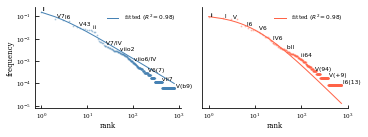

In [26]:
fig, axes = plt.subplots(1,2, figsize=(col_width,2), sharey=True)

for i, (unigrams, color) in enumerate(zip([major_unigrams, minor_unigrams], ['steelblue', 'tomato'])):

    counts = unigrams.values
    tokens = unigrams.index

    # Zipf plot
    ranks = np.arange(1, len(counts)+1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]

    axes[i].loglog(ranks, frequencies, marker=".", c=color, alpha=0.3, lw=0,markersize=2,)
    axes[i].set_xlabel("rank")

    ## fit curve to empirical data

    # Optimal values for the parameters so that 
    # the sum of the squared residuals of 
    # f(xdata, *popt) - ydata is minimized
    popt, pcov = curve_fit(zipf_mandelbrot, ranks, frequencies)
    residuals = frequencies - zipf_mandelbrot(ranks, *popt)
    ss_res = np.sum(residuals**2) # residual sum of squares
    ss_tot = np.sum((frequencies - np.mean(frequencies))**2) # total sum of squares
    #https://en.wikipedia.org/wiki/Coefficient_of_determination
    r_squared = round(1 - (ss_res / ss_tot), 2)

    axes[i].loglog(
            ranks, zipf_mandelbrot(ranks, *popt), 
            c=color,
            linestyle= '-',
            lw=1,
            label=f' fitted $(R^2={r_squared})$',
            alpha=1
        )

    # labels
    for n in list(np.logspace(-0.5, np.log10(len(counts)-1), 12).astype(int)):
        txt = axes[i].text(
            ranks[n],frequencies[n], " " + tokens[indices[n]], 
            family='sans-serif',
            verticalalignment="bottom",
            horizontalalignment="left", 
            size=6, 
            alpha=1,#.6,
        )

    axes[i].legend(frameon=False)

axes[0].set_ylabel("frequency")
axes[0].tick_params(which='minor', left=False, bottom=False)
axes[1].tick_params(which='both', left=False)
axes[1].tick_params(which='minor', bottom=False)
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.16, top=0.97, wspace=0.02)

plt.tight_layout()
plt.savefig('img/Fig5.tif', dpi=dpi)
plt.savefig('img/Fig5.png', dpi=dpi)

plt.show()

In [27]:
maj_Is = all_major_segments[all_major_segments.numeral == 'I' ]
maj_Vs = all_major_segments[all_major_segments.numeral == 'V' ]

In [28]:
print(f'In major segments, there are {maj_Is.shape[0]} ({round(maj_Is.shape[0]/all_major_segments.shape[0]*100,2)}%) I chords,' 
      + f'and {maj_Vs.shape[0]} V chords ({round(maj_Vs.shape[0]/all_major_segments.shape[0]*100,2)}%), '
      + f'together {round(maj_Is.shape[0]/all_major_segments.shape[0]*100 + maj_Vs.shape[0]/all_major_segments.shape[0]*100,2)}%')

In major segments, there are 4324 (26.14%) I chords,and 6706 V chords (40.53%), together 66.67%


In [29]:
min_Is = all_minor_segments[all_minor_segments.numeral == 'i' ]
min_Vs = all_minor_segments[all_minor_segments.numeral == 'V' ]

In [30]:
print(f'In minor segments, there are {min_Is.shape[0]} ({round(min_Is.shape[0]/all_minor_segments.shape[0]*100,2)}%) i chords,' 
      + f'and {min_Vs.shape[0]} V chords ({round(min_Vs.shape[0]/all_minor_segments.shape[0]*100,2)}%), '
      + f'together {round(min_Is.shape[0]/all_minor_segments.shape[0]*100 + min_Vs.shape[0]/all_minor_segments.shape[0]*100,2)}%')

In minor segments, there are 1852 (16.03%) i chords,and 4422 V chords (38.28%), together 54.32%


## Referentiality: Chord transitions

### Chord Transitions

In [31]:
top = 25

# Since no prediction is involved in the analyses, we refrain from smoothing
smooth = 0

In [32]:
major_bigrams = pd.DataFrame(smooth, index=major_unigrams.index, columns=major_unigrams.index)

for seg in major_segments:
    for bg in  cs.grams(seg.token.values, 2):
        major_bigrams.loc[bg[0], bg[1]] += 1

# drop all-zero rows
major_bigrams = major_bigrams.loc[(major_bigrams!=0).any(axis=1)]

In [33]:
minor_bigrams = pd.DataFrame(smooth, index=minor_unigrams.index, columns=minor_unigrams.index)

for seg in minor_segments:
    for bg in cs.grams(seg.token.values, 2):
        minor_bigrams.loc[bg[0], bg[1]] += 1

minor_bigrams = minor_bigrams.loc[(minor_bigrams!=0).any(axis=1)]

In [34]:
data_maj = major_bigrams.div(major_bigrams.sum(axis=1), axis=0) * 100
data_min = minor_bigrams.div(minor_bigrams.sum(axis=1), axis=0) * 100

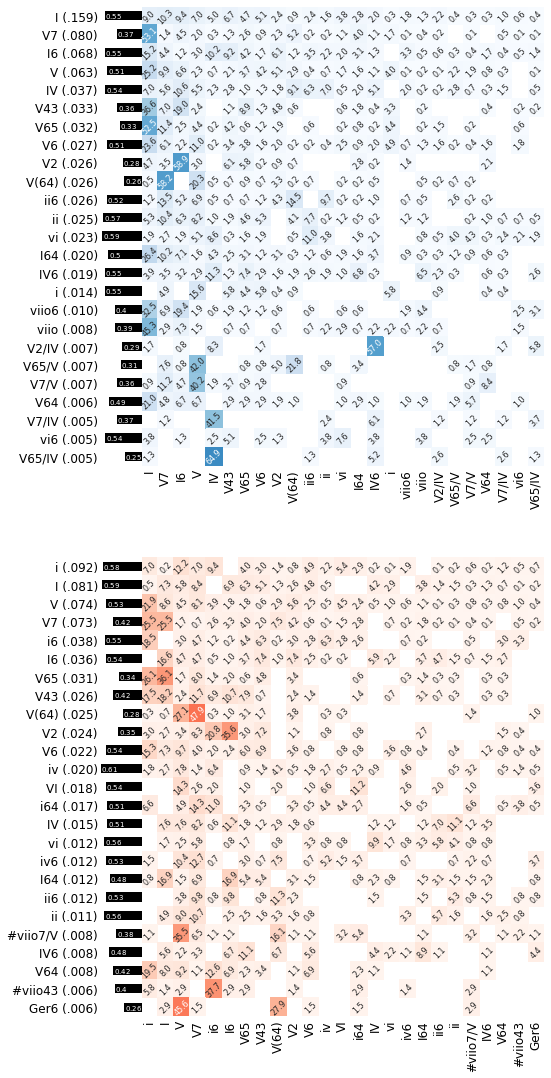

In [37]:
# set custom context for this plot
with plt.rc_context({
    # disable spines for entropy bars
    'axes.spines.top': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.right': False,
    'font.family':'sans-serif',
}):
    # settings for margins etc.
    barsize = [.0, .6]
    gridspec_ratio = [1/10, 1.]
    top_margin = .99
    bottom_margin = .055
    hspace = None
    wspace = 0.0
    right_margin = 1-.005
    left_margin = .175

    fig = plt.figure(figsize=(max_width,max_width*2))
    
    ### MAJOR BIGRAMS

    gs = gridspec.GridSpec(2,2, width_ratios=gridspec_ratio)
    gs.update(left=left_margin, 
              right=right_margin, 
              wspace=wspace,
              hspace=hspace, 
              bottom=bottom_margin, 
              top=top_margin
)

    ax1 = plt.subplot(gs[0, 0])

    vmin = 0
    vmax = 100

    s_maj = pd.Series(
        (data_maj.apply(lambda x: entropy(x, base=2), axis=1) / np.log2(data_maj.shape[0]))[:top].values,
#         data_maj.apply(lambda x: entropy(x, base=2), axis=1)
        index=[
            i +' ('+ '{:.3f})'.format(fr)[1:] 
            for i,fr in zip(data_maj[:top].index, major_unigrams.values[:top])
        ]
    )
    ax = s_maj.plot(kind='barh', ax=ax1, color='k')

    # create a list to collect the plt.patches data
    totals_maj = []
    # find the values and append to list
    for i in ax.patches:
        totals_maj.append(round(i.get_width(), 2))

    for i, p in enumerate(ax.patches):
        # entropy values
        ax1.text(
            totals_maj[i]-0.01, 
            p.get_y()+0.25, 
            f'${totals_maj[i]}$',
            color='w',
            fontsize=7,
            verticalalignment='center',
            horizontalalignment='left'            
        )
    ax1.set_xlim(barsize)
    ax1.invert_yaxis()
    ax1.invert_xaxis()
    ax1.set_xticklabels([])
    ax1.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,
        bottom=False,
        labelleft=True,
        labelsize=12
    )

    ax2 = plt.subplot(gs[0,1])
    
    sns.heatmap(data_maj[data_maj>0].iloc[:top, :top], # only display non-zero values
                annot=True, 
                fmt='.1f',
                cmap='Blues',
                ax=ax2,
                vmin=vmin,
                vmax=vmax,
                annot_kws={
                    'fontsize':8,
                    'rotation':45
                },
                cbar=False,
               )
    ax2.set_yticks([])
    ax2.tick_params(bottom=False, rotation=90,labelsize=12)

    ### MINOR BIGRAMS

    ax3 = plt.subplot(gs[1, 0])

    s_min = pd.Series(
#         (data_min.apply(entropy, axis=1) / np.log2(data_min.shape[0]))[:top].values,
        (data_min.apply(lambda x: entropy(x, base=2), axis=1) / np.log2(data_min.shape[0]))[:top].values,
        index=[
            i +' ('+ '{:.3f})'.format(fr)[1:] 
            for i,fr in zip(data_min.index, minor_unigrams[:top].values) ])
    ax = s_min.plot(kind='barh', ax=ax3, color='k')

    # create a list to collect the plt.patches data
    totals_min = []

    # find the values and append to list
    for i in ax.patches:
        totals_min.append(round(i.get_width(), 2))

    for i, p in enumerate(ax.patches):
        ax3.text(
            totals_min[i]-0.01, 
            p.get_y()+0.25, 
            f'${totals_min[i]}$',
            color='w',
            fontsize=7,
            verticalalignment='center',
            horizontalalignment='left'            
        )
    ax3.set_xlim(barsize)

    ax3.invert_yaxis()
    ax3.invert_xaxis()
    ax3.set_xticklabels([])
    ax3.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,
        bottom=False,
        labelleft=True,
        labelsize=12
    )

    ax4 = plt.subplot(gs[1, 1])

    sns.heatmap(data_min[data_min>0].iloc[:top, :top], # only display non-zero values
                annot=True, 
                fmt='.1f',
                cmap='Reds',
                ax=ax4,
                vmin=vmin,
                vmax=vmax,
                annot_kws={
                    'fontsize':8,
                    'rotation':45
                },
                cbar=False,
               )

    ax4.set_yticks([])
    ax4.tick_params(bottom=False, rotation=90,labelsize=12)

    fig.align_labels()
    
# plt.tight_layout()
#     plt.savefig('img/Fig2.tif', dpi=dpi)
plt.savefig('img/Fig6.tif', dpi=dpi)
plt.savefig('img/Fig6.png', dpi=dpi)

In [38]:
major_numeral_bgs = [ cs.grams(seg.numeral, n=2)  for seg in major_segments ]
major_numeral_bgs = [el for sublist in major_numeral_bgs for el in sublist ]

In [39]:
s = pd.Series(major_numeral_bgs).value_counts(normalize=True)

In [40]:
Ones = 0.0 # 'I'
Fives = 0.0 # 'V'
One_Five = 0.0 # ('I', 'V')
Five_One = 0.0 # ('V', 'I')

for (k1, k2), v in s.items():
    if 'I' in (k1, k2):
        Ones+=v
    if 'V' in (k1, k2):
        Fives+=v
    if (k1, k2) == ('I', 'V'):
        One_Five+=v
    if (k1, k2) == ('V', 'I'):
        Five_One+=v
        
Ones = round(Ones, 3)
Fives = round(Fives, 3)
One_Five = round(One_Five, 3)
Five_One = round(Five_One, 3)

In [41]:
print(f'In major segments, there are {Ones*100}% bigrams with I and {Fives*100}% bigrams with V. {One_Five*100}% of all bigrams proceed from I to V, and {Five_One*100}% from V to I.')

In major segments, there are 44.9% bigrams with I and 64.9% bigrams with V. 10.9% of all bigrams proceed from I to V, and 14.7% from V to I.


In [42]:
minor_numeral_bgs = [ cs.grams(seg.numeral, n=2)  for seg in minor_segments ]
minor_numeral_bgs = [el for sublist in minor_numeral_bgs for el in sublist ]

In [43]:
s = pd.Series(minor_numeral_bgs).value_counts(normalize=True)

In [44]:
ones = 0.0 # 'i'
fives = 0.0 # 'V'
one_five = 0.0 # ('i', 'V')
five_one = 0.0 # ('V', 'i')

for (k1, k2), v in s.items():
    if 'I' in (k1, k2):
        ones+=v
    if 'V' in (k1, k2):
        fives+=v
    if (k1, k2) == ('I', 'V'):
        one_five+=v
    if (k1, k2) == ('V', 'I'):
        five_one+=v
        
ones = round(ones, 3)
fives = round(fives, 3)
one_five = round(one_five, 3)
five_one = round(five_one, 3)

In [45]:
print(f'In minor segments, there are {round(ones*100,2)}% bigrams with i and {round(fives*100,2)}% bigrams with V. {round(one_five*100,2)}% bigrams proceed from i to V, and {five_one*100}% from V to i.')

In minor segments, there are 23.8% bigrams with i and 62.4% bigrams with V. 5.8% bigrams proceed from i to V, and 7.3% from V to i.


### Feature Entropies

In [46]:
features = ['suspended', 'inverted', 'over_pedal', 'applied'] # binary values 
chord_parts = ['changes', 'figbass', 'pedal', 'relativeroot'] # parts of the chord symbol

In [47]:
for i, (f, part) in enumerate(zip(features, chord_parts)):
    # mark all chords that have feature f
    if part == 'figbass':
        data[f] = [1 if v in ['6', '64', '65', '43', '2'] else 0 for v in data[part].values] # exclude zeroth inversions
    else:
        data[f] = np.where(data[part].notnull(), 1, 0)
    
    # arrays of unique chord symbols with/without feature f
    with_feature = data[ data[f] == 1 ].token.unique()
    without_feature = data[ data[f] == 0 ].token.unique()
    
# Mark if a chord symbol has an alterated scale degree
data['altered'] = [1 if type(v)==str and ('#' in v or 'b' in v) 
                   else 0 
                   for v in data.numeral.values] 

if 'altered' not in features:
    features = features + ['altered']

In [48]:
for feature in features:
    feature_chords = data[ data[feature]==1 ]['token'].unique()
    print(feature+': \n   ', feature_chords[:12], len(feature_chords))

suspended: 
    ['V(64)' '#viio7(6)/vi' '#viio7(4)/ii' 'ii6(11#7b6)' 'V(6)' '#viio7(b4)/V'
 'V7(4)' 'V7(4)/IV' 'ii6(9#4)' 'I6(6)' 'V2(6)' 'VI6(6)'] 594
inverted: 
    ['IV6' 'V65' 'ii6' 'ii6(11#7b6)' 'ii6(9#4)' 'I6' 'V64' 'V43' 'I6(6)'
 'V2(6)' 'V2' 'V65/vi'] 616
over_pedal: 
    ['I6' 'V64' 'V43' 'I6(6)' 'V2(6)' 'V2' 'I64' 'V7' 'I' 'It6' 'iv6' 'iv'] 317
applied: 
    ['#viio7(6)/vi' '#viio7/vi' '#viio7(4)/ii' '#viio7/ii' '#viio7(b4)/V'
 '#viio7/V' 'V7(4)/IV' 'V7/IV' 'V65/vi' 'V65/V' 'V43/VI' 'viio65/VII'] 369
altered: 
    ['#viio7(6)/vi' '#viio7/vi' '#viio7(4)/ii' '#viio7/ii' '#viio7(b4)/V'
 '#viio7/V' '#viio65' '#viio65/ii' 'bVI' '#viio' '#viio7' '#viio43'] 220


In [49]:
data.iloc[:,22:].sample(5)

suspended  inverted  over_pedal  applied  altered
11628          0         0           0        0        0
19222          0         0           0        0        0
23913          0         0           0        0        0
25435          0         1           0        0        0
20298          0         1           0        0        0

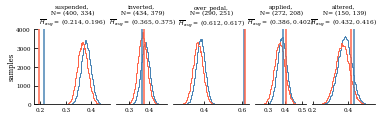

Wall time: 3min 21s


In [50]:
%%time


all_resampled_means = []
all_mus = []
mu_0s = []

Ns = np.zeros((5,2), dtype='int')
H_avgs = np.zeros((5,2), dtype='float')

margin = 0.02
fig, axes = plt.subplots(
    1, len(features), figsize=(col_width,1.5), sharey=True,
    gridspec_kw = {'width_ratios':[0.3, 0.2, 0.3, 0.2, 0.25]}
                        )

for k, (transitions, color) in enumerate(zip([major_bigrams, minor_bigrams], ['steelblue', 'tomato'])):

    entropies = transitions.apply(cs.normalized_entropy, axis=1).values
    mu_0 = np.mean(entropies)
    mu_0s.append(mu_0)

    for i, f in enumerate(features):
        # select chords with feature `f`
        feature_chords = data[data[f] == 1].token.unique()

        feature_entropies = [] # only for chords in given mode
        for chord in feature_chords:
            # only if chord occurs in given mode
            if chord in transitions.index:
                counts = transitions.loc[chord, :]
                H = cs.normalized_entropy(counts)
                feature_entropies.append(H)
        mu = np.mean(feature_entropies)
        Ns[i,k] += len(feature_entropies)

        resampled_means, p = cs.onesamp_bootstrap(feature_entropies, mu_0, N_B=N_B)

        H_avgs[i,k] += mu
        all_resampled_means.append(resampled_means)

        axes[i].hist(resampled_means, histtype='step', color=color, bins=100)
        axes[i].axvline(mu, color=color, linestyle='-')
        x_min = min(mu, min(resampled_means)) - margin
        x_max = max(mu, max(resampled_means)) + margin
        axes[i].set_xlim(x_min, x_max)

axes[0].set_ylabel('samples')

Ns = np.asarray(Ns).reshape(5,2)
H_avgs = np.asarray(H_avgs).reshape(5,2)


for i, (ax, f) in enumerate(zip(axes, features)):
    ax.set_title(
            f'{f},\n N= { Ns[i][0], Ns[i][1] }' 
        + '\n $\overline{H}_{avg}=$ ' + f'{round(H_avgs[i][0], 3), round(H_avgs[i][1], 3)}',
            fontsize=6
        )
for i in range(1,5):
    axes[i].tick_params(left=False)
    axes[i].spines['left'].set_visible(False)

plt.subplots_adjust(left=0.08, right=.99, bottom=0.08, top=.78,wspace=0.1)
plt.savefig('img/Fig3.tif', dpi=dpi)
plt.savefig('img/Fig3.png', dpi=dpi)
plt.show()

### Inspect applied chords

In [51]:
# select all applied chords
s = data[ data['applied']==1 ]['token']
s.head(), s.shape

(14    #viio7(6)/vi
 15       #viio7/vi
 16    #viio7(4)/ii
 17       #viio7/ii
 25    #viio7(b4)/V
 Name: token, dtype: object, (3498,))

In [52]:
s.nunique()

369

In [53]:
for mode in [major_bigrams, minor_bigrams]:

    expected = [] # chords after '/'
    surprised = [] # chord following an applied chord

    for i, chord in s.iteritems():
        if chord in mode.index:
            # only the roots are matched because applied chords are relative to a root
            pattern = r'[#b]*[IViv]*' 
            
            implied = chord.split('/')[1] 
            conseq = re.match(pattern, chord).group()

            if implied == conseq:
                expected.append(1)
            else:
                surprised.append(1)
    print('Implied chord follows', '\t', 'Implied chord does not follow')
    print(sum(expected),'\t\t\t',  sum(surprised))
    print(round(sum(expected)/sum(expected+surprised), 3),'\t\t\t', round(sum(surprised)/sum(expected+surprised),3))
    print('\n')

Implied chord follows 	 Implied chord does not follow
689 			 2641
0.207 			 0.793


Implied chord follows 	 Implied chord does not follow
670 			 2567
0.207 			 0.793




## Directedness: Asymmetry of chord progressions

In [54]:
major_bigrams.sum(axis=0).sum(), minor_bigrams.sum(axis=0).sum()

(16187, 10979)

### General Asymmetry

This takes quite a long time (~20 mins.). The files `asymmetry_resamples.pkl` and `mus.pkl` contain precalculated values.

In [55]:
# %%time

# mus = []
# resamples = []

# for i, df in enumerate([major_bigrams, minor_bigrams]):

#     np.fill_diagonal(df.values, 0) # remove repetitions
#     ratios = []

#     for idx in df.index:
#         for col in df.columns:
#             if col in df.index: # can only calculate ratio of both bigrams exist
#                 AB = df.loc[idx, col]
#                 BA = df.loc[col, idx]
#                 if AB != 0 and BA != 0:
#                     ratio = AB/BA if AB <= BA else BA/AB
#                     ratios += [ratio] * (AB+BA)
#     mu = np.mean(ratios)
#     mus.append(mu)

#     resampled_ratios, p = cs.onesamp_bootstrap(ratios, 1., N_B=N_B)
#     resamples.append(resampled_ratios)
    
# with open('asymmetries.pkl', 'wb') as f:
#     pickle.dump(resamples, f)
    
# with open('mus.pkl', 'wb') as f:
#     pickle.dump(mus, f)

In [56]:
with open('asymmetry_resamples.pkl', 'rb') as f:
    resamples = pickle.load(f)
    
with open('mus.pkl', 'rb') as f:
    mus = pickle.load(f)

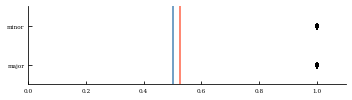

In [59]:
fig, ax = plt.subplots(figsize=(5,1.5))

colors = ['steelblue', 'tomato']

ax.boxplot(resamples, medianprops={'color':'black'}, vert=False,sym='')
for i in range(2):
    ax.axvline(mus[i], color=colors[i])
ax.set_yticklabels(['major', 'minor'])
plt.xlim(0,1.1)
plt.tight_layout()
plt.savefig('img/Fig8.tif', dpi=dpi)
plt.savefig('img/Fig8.png', dpi=dpi)
plt.show()

### Authentic vs. Plagal

In [62]:
progressions = [ ]
for seg in major_segments+minor_segments:
    nums = seg.numeral.dropna()
    for bg in cs.grams(nums.values, 2):
        progressions.append(cs.root_distance_asc(bg[0], bg[1]))
        
progressions = pd.Series(progressions)
normalized_progressions = progressions.value_counts(normalize=True)

In [63]:
plot_order = [0, 4, 5, 2, 7, 6, 3]

In [68]:
# %%time

# progs = (np.asarray([progressions
#                      .sample(n=progressions.shape[0], replace=True)
#                      .value_counts(normalize=True)
#                      .reindex(plot_order) for i in range(N_B)]))

# prog_means = np.mean(progs, axis=0)
# prog_errors = np.std(progs, axis=0)

# with open('prog_means.pkl', 'wb') as f:
#     pickle.dump(prog_means, f)

# with open('prog_errors.pkl', 'wb') as f:
#     pickle.dump(prog_errors, f)

In [69]:
with open('prog_means.pkl', 'rb') as f:
    prog_means = pickle.load(f)
    
with open('prog_errors.pkl', 'rb') as f:
    prog_errors = pickle.load(f)

### Plot

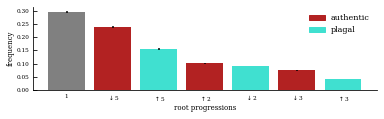

In [71]:
colors = ['grey' if k==0 else 'firebrick' if k%2!=0 else 'turquoise' for k, v in progressions.items()]
labels = ['X', '1', r'$\downarrow$5', r'$\uparrow$5', r'$\uparrow$2', r'$\downarrow$2', r'$\downarrow$3', r'$\uparrow$3' ]

fig, ax = plt.subplots(figsize=(col_width,1.5))
ax.bar(np.arange(7), prog_means, color=colors, yerr=prog_errors)
authentic = mpatches.Patch(color='firebrick', label='authentic')
plagal = mpatches.Patch(color='turquoise', label='plagal')
plt.legend(handles=[authentic, plagal], fontsize=8)
ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel('frequency')
ax.set_xlabel('root progressions')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are on
plt.subplots_adjust(left=0.07, right=.99, bottom=0.2, top=.97)
plt.savefig('img/Fig10.tif', dpi=dpi)
plt.savefig('img/Fig10.png', dpi=dpi)
plt.show()

In [72]:
static = prog_means[0].round(3)
auth = sum([prog_means[i] for i in [1, 3, 5]]).round(3) # indeces not step sizes
plag = sum([prog_means[i] for i in [2, 4, 6]]).round(3) # indeces not step sizes

In [73]:
print(f'Static: \t{static}\nAuthentic:\t{auth}\nPlagal: \t{plag}')

Static: 	0.295
Authentic:	0.416
Plagal: 	0.289


## Hierarchy: Relationship between Chords and Keys

In [74]:
chord_unigrams = pd.Series([ch for ch in data.numeral if ch not in ['Ger', 'Fr', 'It']]).dropna()
key_unigrams = data.local_key.dropna()

In [75]:
chord_unigrams.head(10)

0     I
1     V
2     I
3    IV
4     V
5     I
6    vi
7    ii
8     V
9     V
dtype: object

In [76]:
key_unigrams.head(10)

0    I
1    I
2    I
3    I
4    I
5    I
6    I
7    I
8    I
9    I
Name: local_key, dtype: object

In [77]:
chord_bigrams = cs.grams(chord_unigrams, 2)
key_bigrams = cs.grams(key_unigrams, 2)

In [78]:
chord_bigrams[:10]

[('I', 'V'),
 ('V', 'I'),
 ('I', 'IV'),
 ('IV', 'V'),
 ('V', 'I'),
 ('I', 'vi'),
 ('vi', 'ii'),
 ('ii', 'V'),
 ('V', 'V'),
 ('V', 'I')]

In [79]:
key_bigrams[:10]

[('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I'),
 ('I', 'I')]

In [80]:
alphabet = set(chord_unigrams.value_counts().index).union(set(key_unigrams.value_counts().index))
alphabet = sorted(list(alphabet))

In [81]:
alphabet

['#I',
 '#II',
 '#III',
 '#IV',
 '#V',
 '#VI',
 '#VII',
 '#i',
 '#ii',
 '#iii',
 '#iv',
 '#v',
 '#vi',
 '#vii',
 'I',
 'II',
 'III',
 'IV',
 'V',
 'VI',
 'VII',
 'bI',
 'bII',
 'bIII',
 'bIV',
 'bV',
 'bVI',
 'bVII',
 'bbII',
 'bbV',
 'bi',
 'bii',
 'biii',
 'biv',
 'bv',
 'bvii',
 'i',
 'ii',
 'iii',
 'iv',
 'v',
 'vi',
 'vii']

In [82]:
len(alphabet)

43

In [83]:
N = len(chord_bigrams)
M = len(key_bigrams)

In [84]:
N, M

(27812, 28094)

In [85]:
big_list = pd.Series(chord_bigrams+key_bigrams)

In [86]:
big_list.head(10)

0      (I, V)
1      (V, I)
2     (I, IV)
3     (IV, V)
4      (V, I)
5     (I, vi)
6    (vi, ii)
7     (ii, V)
8      (V, V)
9      (V, I)
dtype: object

### Calculate distances
This takes a very long time (~4.5 hrs). The file `distance.pkl` contains precalculated values.

In [87]:
# %%time

# distances = []
# for i in range(N_B):
#     sample = big_list.sample(N+M, replace=True)
#     chords = sample[:N+1].value_counts()
#     table1 = pd.DataFrame(0, index=alphabet, columns=alphabet)
#     for bg in chords.index:
#         table1.loc[bg[0], bg[1]]+=chords[bg]
        
#     keys = sample[N+1:].value_counts()
#     table2 = pd.DataFrame(0, index=alphabet, columns=alphabet)
#     for bg in keys.index:
#         table2.loc[bg[0], bg[1]]+=keys[bg]
    
#     distance = cosine(table1.values.flatten(), table2.values.flatten())
#     distances.append(distance)

In [88]:
# with open('distance.pkl', 'wb') as f:
#     pickle.dump(distances, f)

In [89]:
with open('distance.pkl', 'rb') as f:
    distances = pickle.load(f)

In [90]:
%%time

markov_table1 = pd.DataFrame(0, index=alphabet, columns=alphabet)
for (k1, k2), v in pd.Series(chord_bigrams).value_counts().items():
    markov_table1.loc[k1, k2] += v

markov_table2 = pd.DataFrame(0, index=alphabet, columns=alphabet)
for (k1, k2), v in pd.Series(key_bigrams).value_counts().items():
    markov_table2.loc[k1, k2] += v
    
null_dist = cosine(markov_table1.values.flatten(), markov_table2.values.flatten())

Wall time: 321 ms


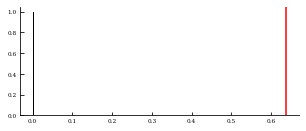

In [104]:
fig = plt.figure(figsize=(5,2))
ax = plt.subplot()
ax.hist(distances, color='black', histtype='step', bins=100)
ax.axvline(null_dist, color='red');

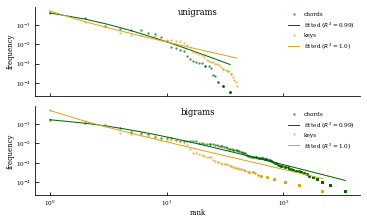

In [253]:
fig, axes = plt.subplots(2,1, figsize=(col_width,col_width/golden_ratio), sharex=True)


d = {
    'unigrams': {
        'chords':chord_unigrams,
        'keys':key_unigrams
    },
    'bigrams': {
        'chords':pd.Series(chord_bigrams),
        'keys':pd.Series(key_bigrams)
    } 
}

func = zipf_mandelbrot 

for i, (key, typ) in enumerate(d.items()):
    for j, (k, v) in enumerate(typ.items()):
        
        colors = ['darkgreen', 'goldenrod']
        
        # calculate rank and frequency
        normalized_counts = v.value_counts(normalize=True)
        ranks = normalized_counts.rank(ascending=False)
        freqs = normalized_counts.values

        # plot rank vs. frequency
        axes[i].loglog(
            ranks, freqs,
            label=k, 
            c=colors[j], 
            marker='.',
            markersize=3,
            lw=0,
            alpha=.5
        )

        ## fit curve to empirical data
        
        # Optimal values for the parameters so that 
        # the sum of the squared residuals of 
        # f(xdata, *popt) - ydata is minimized
        popt, pcov = curve_fit(func, ranks, freqs)
        residuals = freqs - func(ranks, *popt)
        ss_res = np.sum(residuals**2) # residual sum of squares
        ss_tot = np.sum((freqs - np.mean(freqs))**2) # total sum of squares
        #https://en.wikipedia.org/wiki/Coefficient_of_determination
        r_squared = round(1 - (ss_res / ss_tot), 2)
        
        axes[i].loglog(
            ranks, func(ranks, *popt), 
            c=colors[j],
            linestyle= '-',
            lw=1,
            label=f'fitted ($R^2=${r_squared})',
            alpha=1
        )
        
        # plot settings
        axes[i].set(ylabel='frequency')
        axes[i].set_title(key, pad=-8)
        axes[i].tick_params(which='minor', left=False, bottom=False)
        axes[i].legend()
        
plt.subplots_adjust(left=0.105, right=0.995, bottom=0.115, top=0.99, hspace=0.1)
        
axes[1].set_xlabel('rank')
plt.savefig('Fig11.png', dpi=dpi)
plt.savefig('Fig11.tif', dpi=dpi)
plt.tight_layout()
plt.show()